# Download data

In [1]:
!apt install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


In [2]:
%%bash
mkdir -p data
cd data
if [ ! -f "ml-20m.zip" ]; then
    echo "Downloading data"
    wget http://files.grouplens.org/datasets/movielens/ml-20m.zip
    unzip ml-20m.zip
fi


In [3]:
!ls ./data

ml-20m	ml-20m.zip


In [4]:
from argparse import ArgumentParser
import pandas as pd
import numpy as np
import torch
import tqdm

In [5]:
MIN_RATINGS = 20
USER_COLUMN = 'userId'
ITEM_COLUMN = 'movieId'

In [9]:
df = pd.read_csv('./data/ml-20m/ratings.csv')
print("Filtering out users with less than {} ratings".format(MIN_RATINGS))
grouped = df.groupby(USER_COLUMN)
df = grouped.filter(lambda x: len(x) >= MIN_RATINGS)

Filtering out users with less than 20 ratings


In [11]:
df['userId'].value_counts()

118205    9254
8405      7515
82418     5646
121535    5520
125794    5491
74142     5447
34576     5356
131904    5330
83090     5169
59477     4988
130767    4785
79159     4707
8963      4524
15617     4354
92011     4236
71975     4182
20132     4101
46470     4094
88820     4093
63147     3958
130459    3908
120575    3864
9544      3804
31122     3742
18611     3739
125978    3662
18138     3650
91193     3637
111549    3609
68026     3602
          ... 
124891      20
67489       20
83827       20
67451       20
1884        20
14744       20
31120       20
75755       20
18283       20
121892      20
42944       20
116575      20
105519      20
23568       20
14739       20
67408       20
39943       20
83804       20
10201       20
75769       20
138322      20
89146       20
92146       20
105507      20
18290       20
59390       20
23558       20
34668       20
80291       20
58028       20
Name: userId, Length: 138493, dtype: int64

In [12]:
df['movieId'].value_counts()

296       67310
356       66172
318       63366
593       63299
480       59715
260       54502
110       53769
589       52244
2571      51334
527       50054
1         49695
457       49581
150       47777
780       47048
50        47006
1210      46839
592       46054
1196      45313
2858      44987
32        44980
590       44208
1198      43295
608       43272
47        43249
380       43159
588       41842
377       41562
1270      41426
858       41355
2959      40106
          ...  
107238        1
123629        1
107236        1
74478         1
123621        1
116323        1
107248        1
123645        1
107252        1
107147        1
90777         1
123627        1
107241        1
107268        1
123596        1
90883         1
123669        1
90935         1
107316        1
123587        1
107202        1
107204        1
107243        1
99939         1
123600        1
123607        1
90823         1
123609        1
123613        1
131136        1
Name: movieId, Length: 2

In [13]:
import matplotlib.pyplot as plt

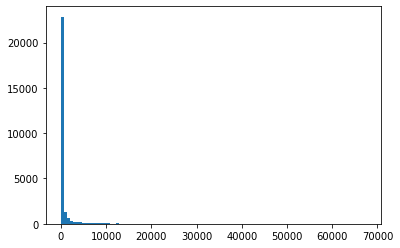

In [18]:
plt.hist(df['movieId'].value_counts(),100);

In [7]:
print("Mapping original user and item IDs to new sequential IDs")
df[USER_COLUMN], unique_users = pd.factorize(df[USER_COLUMN])
df[ITEM_COLUMN], unique_items = pd.factorize(df[ITEM_COLUMN])

np.max(df[ITEM_COLUMN])

Mapping original user and item IDs to new sequential IDs


26743

In [8]:
import pickle

with open('./mappings.pickle', 'wb') as handle:
    pickle.dump({"users": unique_users, "items": unique_items}, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
# Need to sort before popping to get last item
df.sort_values(by='timestamp', inplace=True)

# clean up data
del df['rating'], df['timestamp']
df = df.drop_duplicates() # assuming it keeps order

# now we have filtered and sorted by time data, we can split test data out
grouped_sorted = df.groupby(USER_COLUMN, group_keys=False)
test_data = grouped_sorted.tail(1).sort_values(by=USER_COLUMN)
# need to pop for each group
train_data = grouped_sorted.apply(lambda x: x.iloc[:-1])

In [10]:
train_data['target']=1
test_data['target']=1
train_data.head()

,userId,movieId,target
20,0,20,1
19,0,19,1
86,0,86,1
61,0,61,1
23,0,23,1


In [11]:
sampler = _TestNegSampler(df.values, 100)  # using 100 negative samples
train_negs = sampler.generate()
train_negs = train_negs.reshape(-1, 100)

sampler = _TestNegSampler(df.values, 1)  # using 1 negative samples
test_negs = sampler.generate()
test_negs = test_negs.reshape(-1, 1)

Negative sampler #users 138493 items 26744


  0%|          | 52913/13849300 [00:00<00:26, 529121.67it/s]

Generating validation negatives...


100%|██████████| 13849300/13849300 [00:22<00:00, 626234.63it/s]


Negative sampler #users 138493 items 26744


 38%|███▊      | 52650/138493 [00:00<00:00, 526495.48it/s]

Generating validation negatives...


100%|██████████| 138493/138493 [00:00<00:00, 535942.43it/s]


In [12]:
test_negs.shape

torch.Size([138493, 1])

In [13]:
# train negative data
train_data_neg = np.zeros((train_negs.shape[0]*train_negs.shape[1],3), dtype=int)
idx = 0
for i in range(train_negs.shape[0]):
    for j in range(train_negs.shape[1]):
        train_data_neg[idx, 0] = i
        train_data_neg[idx, 1] = train_negs[i,j]
        idx += 1

In [14]:
# test negative data
test_data_neg = np.zeros((test_negs.shape[0]*test_negs.shape[1],3), dtype=int)
idx = 0
for i in range(test_negs.shape[0]):
    for j in range(test_negs.shape[1]):
        test_data_neg[idx, 0] = i
        test_data_neg[idx, 1] = test_negs[i,j]
        idx += 1

In [15]:
train_data_np= np.concatenate([train_data_neg, train_data.values])
np.random.shuffle(train_data_np)

test_data_np= np.concatenate([test_data_neg, test_data.values])
np.random.shuffle(test_data_np)

In [16]:
np.sum(test_data_np[:,2])

138493

In [17]:
test_data_np

array([[ 35326,   4974,      1],
       [119672,   1857,      1],
       [131643,  14136,      1],
       ...,
       [132644,    920,      1],
       [130708,   1823,      1],
       [ 67488,  26575,      0]])

# Write to text file

In [18]:
rd = np.random.randint(0, 100, size=(33711070,1))
def write_DLRM_data(data, filename='dlrm_data.tsv'):
    print("Writing %d samples"%data.shape[0], filename)
    with open(filename, 'wt') as f:
        for i in tqdm.tqdm(range(data.shape[0])):
            f.write('%d\t%d\t%d\t%d\n'%(data[i,2], rd[i], data[i,0], data[i,1])) #label, dummy numeric feat., userID, itemID

In [19]:
!rm -rf /data/dlrm/
!mkdir -p /data/dlrm/criteo
for i, data_arr in enumerate(np.array_split(train_data_np,23)):
    write_DLRM_data(data_arr, filename='/data/dlrm/criteo/day_%d'%i)

Writing 1465699 samples /data/dlrm/criteo/day_0


  1%|▏         | 21192/1465699 [00:00<00:06, 211914.14it/s]

Writing 1465699 samples /data/dlrm/criteo/day_1


  1%|▏         | 21127/1465699 [00:00<00:06, 211268.69it/s]

Writing 1465699 samples /data/dlrm/criteo/day_2


  1%|▏         | 21361/1465699 [00:00<00:06, 213604.09it/s]

Writing 1465699 samples /data/dlrm/criteo/day_3


  1%|▏         | 21308/1465699 [00:00<00:06, 213072.08it/s]

Writing 1465699 samples /data/dlrm/criteo/day_4


  1%|▏         | 21065/1465699 [00:00<00:06, 210644.68it/s]

Writing 1465699 samples /data/dlrm/criteo/day_5


  1%|▏         | 21240/1465699 [00:00<00:06, 212390.58it/s]

Writing 1465699 samples /data/dlrm/criteo/day_6


  1%|▏         | 21230/1465699 [00:00<00:06, 212291.60it/s]

Writing 1465699 samples /data/dlrm/criteo/day_7


  1%|▏         | 21188/1465699 [00:00<00:06, 211877.68it/s]

Writing 1465699 samples /data/dlrm/criteo/day_8


  3%|▎         | 42430/1465699 [00:00<00:06, 211677.77it/s]

Writing 1465699 samples /data/dlrm/criteo/day_9


  1%|▏         | 21284/1465699 [00:00<00:06, 212830.56it/s]

Writing 1465699 samples /data/dlrm/criteo/day_10


  1%|▏         | 21397/1465699 [00:00<00:06, 213964.08it/s]

Writing 1465699 samples /data/dlrm/criteo/day_11


  1%|▏         | 21235/1465699 [00:00<00:06, 212346.15it/s]

Writing 1465699 samples /data/dlrm/criteo/day_12


  1%|▏         | 21246/1465699 [00:00<00:06, 212458.68it/s]

Writing 1465699 samples /data/dlrm/criteo/day_13


  1%|▏         | 21288/1465699 [00:00<00:06, 212877.16it/s]

Writing 1465699 samples /data/dlrm/criteo/day_14


  1%|▏         | 21241/1465699 [00:00<00:06, 212402.10it/s]

Writing 1465699 samples /data/dlrm/criteo/day_15


  1%|▏         | 21141/1465698 [00:00<00:06, 211401.13it/s]

Writing 1465698 samples /data/dlrm/criteo/day_16


  1%|▏         | 21244/1465698 [00:00<00:06, 212436.15it/s]

Writing 1465698 samples /data/dlrm/criteo/day_17


  1%|▏         | 21224/1465698 [00:00<00:06, 212232.11it/s]

Writing 1465698 samples /data/dlrm/criteo/day_18


  1%|▏         | 21233/1465698 [00:00<00:06, 212329.70it/s]

Writing 1465698 samples /data/dlrm/criteo/day_19


  1%|▏         | 21314/1465698 [00:00<00:06, 213138.68it/s]

Writing 1465698 samples /data/dlrm/criteo/day_20


  1%|▏         | 21288/1465698 [00:00<00:06, 212871.07it/s]

Writing 1465698 samples /data/dlrm/criteo/day_21


  1%|▏         | 21280/1465698 [00:00<00:06, 212797.16it/s]

Writing 1465698 samples /data/dlrm/criteo/day_22


100%|██████████| 1465698/1465698 [00:06<00:00, 229680.46it/s]


In [20]:
!head /data/dlrm/criteo/day_0

0	19	91370	20687
1	70	119206	398
1	77	126716	118
0	5	67368	3692
0	74	33815	6707
1	96	51265	2482
0	99	77632	23178
1	97	129951	730
0	86	21908	26442
1	20	137557	6715


In [21]:
write_DLRM_data(test_data_np, filename='/data/dlrm/criteo/day_23')

  0%|          | 0/276986 [00:00<?, ?it/s]

Writing 276986 samples /data/dlrm/criteo/day_23


100%|██████████| 276986/276986 [00:01<00:00, 224174.67it/s]


In [22]:
!head /data/dlrm/criteo/day_0

0	19	91370	20687
1	70	119206	398
1	77	126716	118
0	5	67368	3692
0	74	33815	6707
1	96	51265	2482
0	99	77632	23178
1	97	129951	730
0	86	21908	26442
1	20	137557	6715


In [23]:
!tail /data/dlrm/criteo/day_23

0	70	70679	19357
0	59	99795	19726
0	65	64765	20586
0	61	12655	1907
1	24	38058	2542
1	77	71403	5079
1	6	134995	624
1	26	132644	920
1	27	130708	1823
0	16	67488	26575


# Preprocessing with DLRM

In [ ]:
%%bash
apt install psmisc
cd ./preproc
killall -9 java
bash ./prepare_dataset.sh

In [27]:
!cat /data/dlrm/binary_dataset/model_size.json


{
    "_c2": 138493,
    "_c3": 26744
}